Last year [Duolingo](http://duolingo.com) published [a paper](https://aclweb.org/anthology/P/P16/P16-1174.pdf) describing a learner model which can be used to describe learners' learning and forgetting. Together with this paper authors published also a [data set containing 13 million learning traces](https://s3.amazonaws.com/duolingo-papers/publications/settles.acl16.learning_traces.13m.csv.gz) allowing other peaple to reproduce the original results. As I've [already written](https://papousek.github.io/analysis-of-half-life-regression-model-made-by-duolingo.html), the original model is realy bad. 

Our [research group](http://www.fi.muni.cz/adaptivelearning/) use learner modeling techniques quite often and my research is focused on [adaptive practice of factual knowledge in domains with varied prior knowledge](http://www.fi.muni.cz/~xpelanek/publications/EDM14-adaptive-facts.pdf). Learning a new language is a good example of this kind of domain. A lot of peaple try to learn a new languge many times (at school, private lessons, ...) and I assume that when a learner starts using Duolingo, she has already some kind of prior knowledge. Our approach to model this phenomenon is to seperate learners' prior knowledge on one side and the process of learning and forgetting on the other side. Of course, we use a learner's prior knowledge as an input to the model of learning.

In the following text, I describe how we usually model prior knowledge and I use data set from Duolingo as an example. The full code of this analysis is available on [GitHub](https://github.com/papousek/duolingo-halflife-regression) and is based on the fork of the original repository to minimize the probability of my error.

If you want to run this Jupyter notebook on your own, please download the [original data set](https://s3.amazonaws.com/duolingo-papers/publications/settles.acl16.learning_traces.13m.csv.gz) to the **data** directory. To be more familiar with the data, please read the [previous analysis](https://papousek.github.io/analysis-of-half-life-regression-model-made-by-duolingo.html).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from evaluation import plot_model_stats
from models import ItemAverage, Elo
from proposal import load_train_test_set, train_model, grid_search
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spiderpig as sp

sns.set(style="white")

To cache intermidiate results I use [spiderpig](https://github.com/papousek/spiderpig), a library I have written on my own for this purpose. Spiderpig has to be initialized and I already decleare some global parameters.

In [3]:
sp.init(
    directory='.spiderpig',
    traces_filename='./data/settles.acl16.learning_traces.13m.csv.gz',
    traces_nrows=1000000,
    max_in_memory_entries=10
)

Since I need to fit some parameters I divide the data to train/test set.

In [4]:
trainset, testset = load_train_test_set()

## Baseline: Item Average

As a baseline I use "item average" model. This model computes the average probability of recall for each item (lexeme) and uses this average for the estimation of the future probability of recall. Although this model is realy stupid, based on our experience it serves as a good baseline. Your model should definitely be better than this.

In [5]:
item_average, _ = train_model('ItemAverage')

To evaluate quality of predictions, we can use a lot of metrics
([AUC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve),
[MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), ...), see [this paper](http://www.fi.muni.cz/~xpelanek/publications/metrics.pdf) for more info Although these metrics are usually very simple, they can have big negative impact on your evaluation. Based on our experience, RMSE serves well in the most cases. To look at predictions more closely, we use "calibration" curve and histogram of predictions. In the optimal case, the calibration curve is aligned with diagonal.

RMSE: 0.27228490201648553
MAE: 0.172331329013
AUC: 0.591816428408


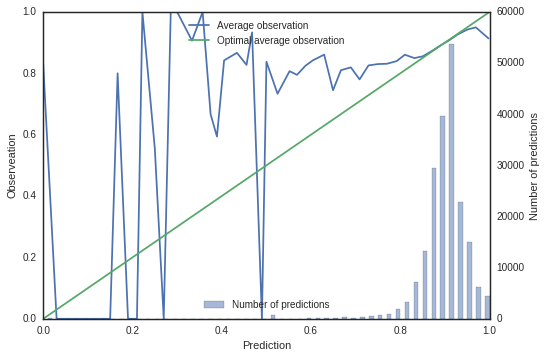

In [6]:
predicted = np.zeros(len(testset))
for i, lexeme_id in enumerate(testset['lexeme_id'].values):
    predicted[i] = item_average.predict(lexeme_id)
plot_model_stats(predicted, testset['p_recall'], 50)

## Elo

For each learner s we track her skill $\theta_s$ and for each item (lexeme) i we track its difficulty $b_i$. When we want to predict the probality of correct answer, we substract item difficulty from a learner's skill and transform it by a logistic function. 

$$
\begin{align}
P(correct_{si} = 1) &= \frac{1}{1 + e^{-(\theta_s - b_i)}}
\end{align}
$$

This model is known as [one-parameter IRT model](https://en.wikipedia.org/wiki/Item_response_theory) (or Rasch model). We can use joint maximum likelihood to fit skills and difficulties, but this method is not applicable online, becuase it needs all data for its computation. To estimate parameters online, we can inspire from [Elo rating system](https://en.wikipedia.org/wiki/Elo_rating_system) originally designed to rate chess players. This method can easily work with a stream of answers. After a learner s solves an item i, we update the learner's skill and the item difficulty as follows (constant K stands for sensitivity of the estimate to the last update and $correct_{si}\in[0, 1]$):

$$
\begin{align}
\theta_s &= \theta_s + K\cdot(correct_{si}- P(correct_{si} = 1)) \\
b_i &= b_i - K\cdot(correct_{si} - P(correct_{si} = 1))
\end{align}
$$

Initially, values of skills $\theta_s$ and difficulties $b_i$ are set to 0. To make the estimate stable and converging we need to replace the sensitivity constant K by an uncertainty function ensuring that later changes have less weight. Without that we could easily lose information from past updates.

$$
K \sim U(n) = \frac{\alpha}{1 + \beta n}
$$

Variable n stands for a number of past updates and a, b are meta-parameters fitted to data.

**Important note**: Since this model does not handle learning, it is necessary to update skills and difficulties only once per each learner and item (we ignore repeated answers).

To fit meta-parameters we use simple grid search.

In [7]:
elo_search = grid_search('Elo', ('alpha', (0.5, 1.5)), ('beta', (0.01, 0.11)))

Best meta-parameters:
alpha    1.100000
beta     0.090000
rmse     0.274141
Name: 94, dtype: float64


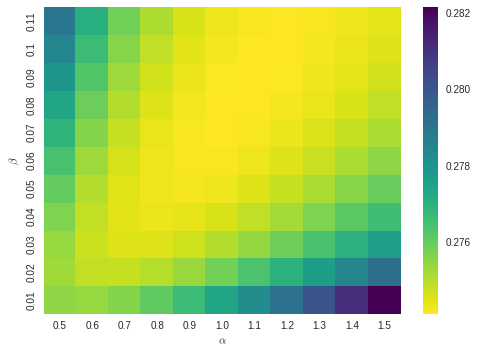

In [8]:
sns.heatmap(
    elo_search.pivot_table(columns='alpha', index='beta', values='rmse', dropna=False).iloc[::-1],
    cmap='viridis_r',
    rasterized=True,
    linewidths=0.0
)
plt.xlabel('$\\alpha$')
plt.ylabel('$\\beta$')
elo_best_params = elo_search.ix[elo_search['rmse'].idxmin()]
print('Best meta-parameters:')
print(elo_best_params)
plt.show()

Based on RMSE, it seems that the improvement in comparison to the baseline is very small, but calibration curve looks much better.

RMSE: 0.26799401976644194
MAE: 0.178118146594
AUC: 0.650661505178


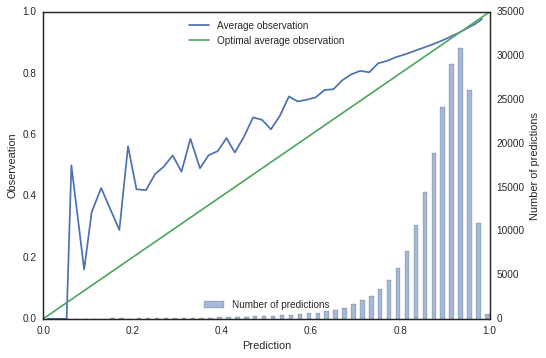

In [9]:
elo, _ = train_model('Elo', alpha=elo_best_params['alpha'], beta=elo_best_params['beta'])
predicted = np.zeros(len(testset))
for i, (user_id, lexeme_id, p_recall) in enumerate(testset[['user_id', 'lexeme_id', 'p_recall']].values):
    predicted[i] = elo.predict(user_id, lexeme_id, p_recall)
plot_model_stats(predicted, testset['p_recall'], 50)

The model also provides us with information about items and learners. Here are histograms of item difficulties and learners' prior skills.

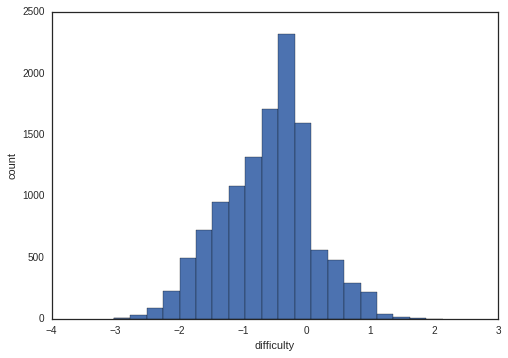

In [10]:
plt.hist(list(elo._difficulty.values()), bins=20)
plt.xlabel('difficulty')
plt.ylabel('count')
plt.show()

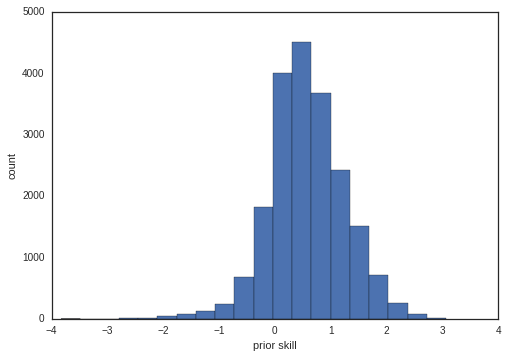

In [11]:
plt.hist(list(elo._skill.values()), bins=20)
plt.xlabel('prior skill')
plt.ylabel('count')
plt.show()

## Conclusion

Using Elo to estimate difficulties of items and learners' skills improves quality of predictions. Still, this model can't provide information shown by skill meters, because the estimated knowledge does not degrade in time. On the other side, estimation from this model can be used as an input for another model handling learning and forgetting, e.g., [PFAE with staircase time shift function](http://www.fi.muni.cz/~xpelanek/publications/memory-geography.pdf).